<a href="https://colab.research.google.com/github/BakhtawarRehman/Facial-Emotion-Recognition/blob/master/bird_specie_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is yet a TODO task.
* preprocessing of the data has been done.
* Model has been trained using transfer learning and results are comparably better than a custom cnn. However, there is a room to improve the results.
* This dataset comes with bounding boxes and segmentation. Next step will to do it using U-NET for segmentation and YOLO for bounding box generation.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import os
import cv2
import glob

%matplotlib inline

Using TensorFlow backend.


In [4]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz

--2020-01-31 20:25:16--  http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 679421896 (648M) [application/x-tar]
Saving to: ‘images.tgz’

images.tgz          100%[===================>] 647.95M  8.69MB/s    in 77s     

2020-01-31 20:26:33 (8.43 MB/s) - ‘images.tgz’ saved [679421896/679421896]



In [0]:
!tar -xf images.tgz

In [6]:
name=[]
paths=[]
for file in glob.glob('./images/*/'):  
  #Class names : It will be used for visualization purposes
  name.append(file[13:-1])
  paths.append(file)

print(name[0])
print(paths[0])

Downy_Woodpecker
./images/192.Downy_Woodpecker/


In [0]:
#saving 80% for training and remaning for test in each category / folder
def percentage (num):
  percentage =  (num * (0.8))
  #trImages = percentage(num)
  tsImages = num - percentage
  return round(percentage), round(tsImages)

#counting # of images
def numOfImages(val):
    return len(list(glob.iglob(path+"*.jpg", recursive=True)))

In [0]:
# training images
train=[]
#test images
test=[]

i=0

#labelsfor train and test images
labelsTrain=[]
labelsTest=[]
totTr=0
totTs=0

for path in paths:
  #saving 80% for training and remaning for test in each category / folder
  tr, ts = percentage(numOfImages(path))    

  totTr += tr
  totTs += ts
  labelsTrain.append(totTr)
  labelsTest.append(totTs)


  for image in glob.glob(path+'*.jpg'):

    if i < tr:
      train.append(mpimg.imread(image))

    else:
      test.append(mpimg.imread(image))
    i+=1


  i=0


In [9]:
print('# of training images: ', len(train))
print('# of test images: ', len(test))
print(len(labelsTrain))
print(len(labelsTest))

# of training images:  4829
# of test images:  1204
200
200


In [10]:
# reshaping images to 220*220 size
train = [cv2.resize(image, (224, 224)) for image in train]
test = [cv2.resize(image, (224, 224)) for image in test]

train=np.array(train)
test=np.array(test)

print (train.shape)
print(type(train))

print (test.shape)
print(type(test))


print(labelsTrain)
print(len(labelsTrain))

print(labelsTest)
print(len(labelsTest))

(4829, 224, 224, 3)
<class 'numpy.ndarray'>
(1204, 224, 224, 3)
<class 'numpy.ndarray'>
[30, 56, 78, 98, 115, 136, 162, 188, 216, 243, 273, 299, 319, 339, 369, 398, 426, 450, 469, 491, 520, 539, 569, 593, 623, 652, 676, 703, 733, 759, 781, 800, 827, 845, 862, 879, 904, 927, 946, 972, 1000, 1027, 1053, 1069, 1088, 1115, 1136, 1157, 1183, 1201, 1228, 1254, 1279, 1301, 1327, 1353, 1383, 1403, 1430, 1453, 1478, 1504, 1528, 1552, 1573, 1595, 1615, 1644, 1665, 1683, 1711, 1735, 1760, 1786, 1808, 1834, 1864, 1886, 1915, 1943, 1968, 1997, 2016, 2034, 2055, 2075, 2091, 2117, 2139, 2159, 2185, 2203, 2228, 2246, 2272, 2296, 2318, 2343, 2365, 2393, 2421, 2450, 2471, 2491, 2512, 2540, 2557, 2584, 2610, 2636, 2656, 2684, 2713, 2736, 2762, 2784, 2809, 2834, 2854, 2883, 2913, 2939, 2957, 2984, 3011, 3036, 3062, 3080, 3106, 3129, 3151, 3173, 3201, 3224, 3247, 3263, 3279, 3305, 3324, 3346, 3368, 3388, 3417, 3444, 3469, 3490, 3518, 3544, 3566, 3592, 3614, 3644, 3670, 3701, 3719, 3743, 3764, 3790, 3808, 3

In [0]:
#assigning labels to each image in test
labTs = np.ones((len(test)),dtype='int64')


for i in range(len(labelsTest)+1):

  if i == 0: 
    labTs[0:labelsTest[i]] = 0

  elif i >= 1 and i < 200:
    labTs[labelsTest[i-1]:labelsTest[i]] = i

  else:
    labTs[labelsTest[i-1]:] = i-1


In [0]:
#assigning labels to each image in train
labTr = np.ones((len(train)),dtype='int64')


for i in range(len(labelsTrain)+1):

  if i == 0: 
    labTr[0:labelsTrain[i]] = 0

  elif i >= 1 and i < 200:
    labTr[labelsTrain[i-1]:labelsTrain[i]] = i

  else:
    labTr[labelsTrain[i-1]:] = i-1


In [13]:
print(labTr)
print (labTs)

[  0   0   0 ... 199 199 199]
[  0   0   0 ... 199 199 199]


In [14]:
#Converting labels into categorical
labTr = np_utils.to_categorical(labTr)
labTs = np_utils.to_categorical(labTs)

print(labTr.shape)
print(labTs.shape)
print(labTr)
print(labTs)

(4829, 200)
(1204, 200)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


<function matplotlib.pyplot.show>

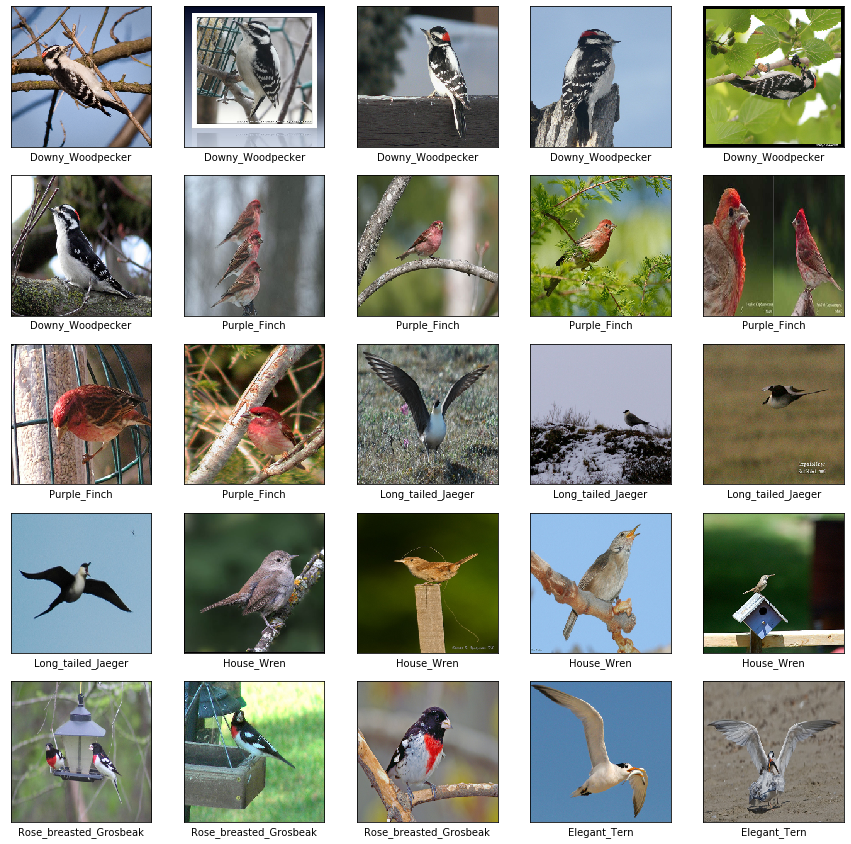

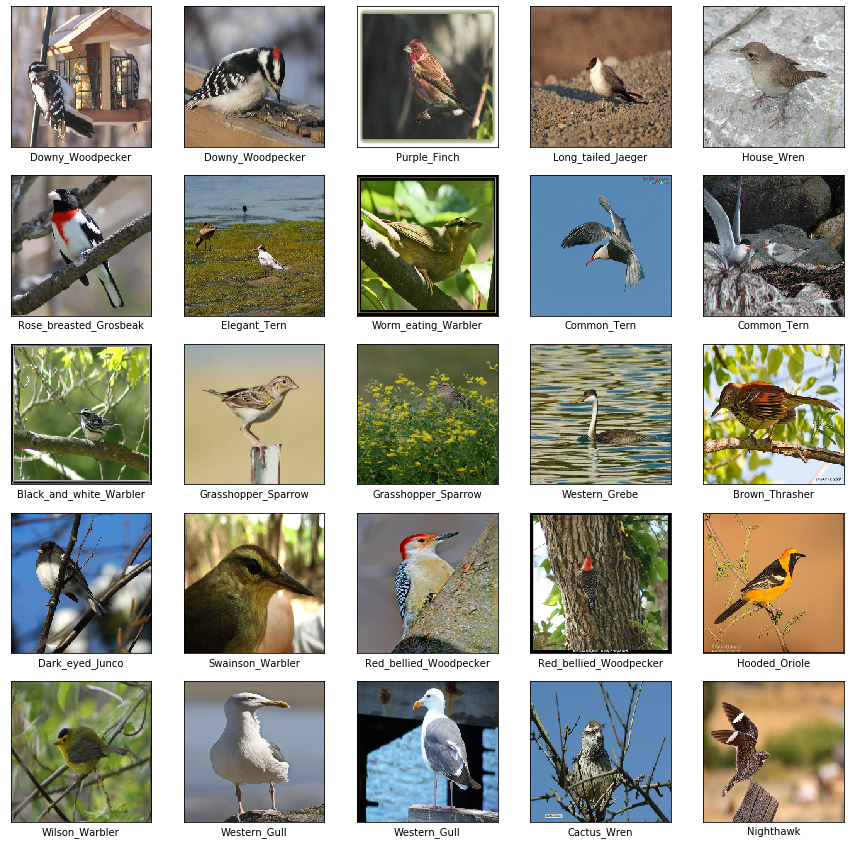

In [15]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(train[i*5])
    plt.xlabel(name[np.argmax(labTr[i*5])])
plt.show


plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(test[i*5])
    plt.xlabel(name[np.argmax(labTs[i*5])])
plt.show

In [0]:

#defining our model
model = keras.Sequential([
                          keras.layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),

                          keras.layers.Dropout(0.3),

                          keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Dropout(0.4),

                          keras.layers.Flatten(),
                          keras.layers.BatchNormalization(),
                          keras.layers.Dense(256, activation='relu'),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(64, activation='relu'),
                          keras.layers.Dense(200, activation='softmax')


])

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   #vertical_flip=True,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1/255.)

In [21]:

# run model
hist = model.fit_generator( train_datagen.flow(train, labTr, batch_size=128), epochs=20,
                 shuffle=True,
                 steps_per_epoch=len(train) // 128,
                 
                 validation_data=test_datagen.flow(test, labTs),
                 verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 38 steps
Epoch 1/20
37/37 [==============================] - 45s 1s/step - loss: 2.7909 - accuracy: 0.2782 - val_loss: 3.7067 - val_accuracy: 0.2193
Epoch 2/20
37/37 [==============================] - 45s 1s/step - loss: 2.7576 - accuracy: 0.2912 - val_loss: 3.8068 - val_accuracy: 0.2035
Epoch 3/20
37/37 [==============================] - 45s 1s/step - loss: 2.7386 - accuracy: 0.3074 - val_loss: 3.7739 - val_accuracy: 0.2209
Epoch 4/20
37/37 [==============================] - 45s 1s/step - loss: 2.7377 - accuracy: 0.2914 - val_loss: 3.9458 - val_accuracy: 0.2060
Epoch 5/20
37/37 [==============================] - 45s 1s/step - loss: 2.7366 - accuracy: 0.3061 - val_loss: 3.7613 - val_accuracy: 0.2068
Epoch 6/20
37/37 [==============================] - 45s 1s/step - loss: 2.7275 - accuracy: 0.3001 - val_loss: 3.6884 - val_accuracy: 0.2151
Epoch 7/20
37/37 [==============================] - 45s 1s/step - lo

1204/1204 - 0s - loss: 935.2171 - accuracy: 0.0365


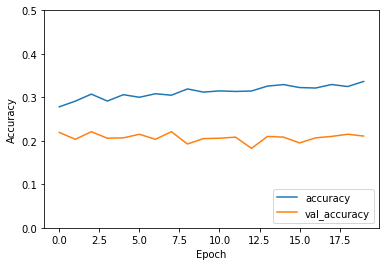

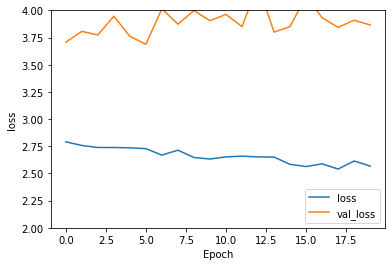

<Figure size 432x288 with 0 Axes>

In [29]:

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
plt.figure()


plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([2, 4])
plt.legend(loc='lower right')
plt.figure()

test_loss, test_acc = model.evaluate(test,  labTs, verbose=2)

In [15]:

#google drive to load files from
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
local_weights_file = "/content/drive/My Drive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (224,224,3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [38]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x=keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = keras.layers.Dropout(0.4)(x)     

x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)   

# Add a final sigmoid layer for classification
x = keras.layers.Dense  (200, activation='softmax')(x)           

model = keras.models.Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [40]:
# run model
hist = model.fit_generator( train_datagen.flow(train, labTr, batch_size=128), epochs=200,
                 shuffle=True,
                 steps_per_epoch=len(train) // 128,
                 #callbacks=[reduce_lr_loss],
                 validation_data=test_datagen.flow(test, labTs),
                 verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 38 steps
Epoch 1/200
37/37 [==============================] - 56s 2s/step - loss: 7.9323 - acc: 0.0087 - val_loss: 5.2975 - val_acc: 0.0075
Epoch 2/200
37/37 [==============================] - 52s 1s/step - loss: 5.3710 - acc: 0.0074 - val_loss: 5.2968 - val_acc: 0.0075
Epoch 3/200
37/37 [==============================] - 52s 1s/step - loss: 5.3197 - acc: 0.0087 - val_loss: 5.2951 - val_acc: 0.0100
Epoch 4/200
37/37 [==============================] - 52s 1s/step - loss: 5.2997 - acc: 0.0121 - val_loss: 5.2839 - val_acc: 0.0116
Epoch 5/200
37/37 [==============================] - 52s 1s/step - loss: 5.2829 - acc: 0.0130 - val_loss: 5.2759 - val_acc: 0.0125
Epoch 6/200
37/37 [==============================] - 52s 1s/step - loss: 5.2518 - acc: 0.0145 - val_loss: 5.2672 - val_acc: 0.0150
Epoch 7/200
37/37 [==============================] - 52s 1s/step - loss: 5.2170 - acc: 0.0192 - val_loss: 5.2107 - val_acc